In [1]:
import gensim
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from lime import lime_text
import tensorflow.keras.preprocessing
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from os.path import exists

In [2]:
train = pd.read_csv('data/reddit_200k_train.csv', encoding='ISO-8859-1')
test = pd.read_csv('data/reddit_200k_test.csv', encoding='ISO-8859-1')

In [3]:
train.head()
#score.x appears to be upvotes?

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,1,I've always been taught it emerged from the earth after an impace. That is why it has similar elemental distribution to earth,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,2,"As an ECE, my first feeling as ""HEY THAT'S NOT-"" and then I thought about all the times my co-workers couldn't even write a simple message in our communication book without making mistakes. \r\n\r\nI'm getting out of the profession.",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,3,Monday: Drug companies stock dives on good news for patients.,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,4,i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,5,Well i was wanting to get wasted tonight. Not so much after reading this article...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [4]:
print('Length of train split:', len(train))
print('Length of test split:', len(test))
print('Relative test split size:', 1/((len(test)+len(train))/len(test)))

Length of train split: 167529
Length of test split: 55843
Relative test split size: 0.25


Label distribution:
 False    0.61492
True     0.38508
Name: REMOVED, dtype: float64


Text(1.93, 0.43507959815912467, '38.51%')

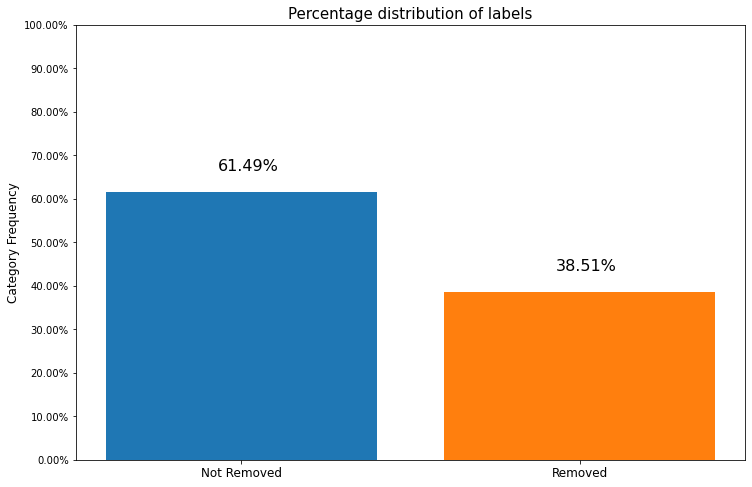

In [5]:
percentage_not_removed = pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True)[0]
percentage_removed = pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True)[1]
print('Label distribution:\n', pd.concat([train['REMOVED'], test['REMOVED']]).value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(1, percentage_not_removed, label='Not Removed')
ax.bar(2, percentage_removed, label='Removed')
ax.set_title('Percentage distribution of labels', fontsize=15)
plt.xticks([1,2],['Not Removed', 'Removed'], fontsize=12)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Category Frequency', fontsize=12)
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.text(1 -0.07, percentage_not_removed + 0.05, "{:.2%}".format(percentage_not_removed), fontsize=16)
plt.text(2 -0.07, percentage_removed + 0.05, "{:.2%}".format(percentage_removed), fontsize=16)

In [6]:
# Comment removal messages are contained in this set, too.
# Since these are automated or from moderators, they do not 
# represent the kinds of comments the model will actually be working with.
train.loc[train['body'].str.contains('has been removed because')]

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
425,426,"Hi Z0idberg_MD, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=M...",4,t3_78bxng,dosmmc6,1508803513,1510120310,False
470,471,"Hi 432_Hz, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%20P...",2,t3_7gu35y,dqlpg3r,1512123314,1514226457,True
1736,1737,"Hi xxxlovelit, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My...",0,t3_9hqtmi,e6dssic,1537543212,1539369659,True
1890,1891,"Hi FM9022, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%20P...",2,t3_7eywxu,dq8cqef,1511435412,1512927391,True
1972,1973,"Hi kolorful, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=My%2...",2,t3_5x6s6e,defpo78,1488497714,1491157692,False
...,...,...,...,...,...,...,...,...
164288,164289,"Hi drewiepoodle, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic. If you feel this was done in error, or would like further clarification, please add flair to the post and then [message the mods](http://www.reddit.com/message/compose?to=%2Fr%2FScience&amp;amp;message=...",0,t3_8nj7gg,dzvukp6,1527780311,1528193263,True
164987,164988,"Your submission has been removed because it violates our submission rules. Please read the [Rules for Headlines](https://www.reddit.com/r/science/wiki/clickbait) and contact the mods if you have further questions.\r\n\r\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/science) if you have any questions or conce...",2,t3_5n65jd,dc8x5ab,1484067606,1485934698,False
165061,165062,"Your submission has been removed because it violates our submission rules. Please read the [Rules for Headlines](https://www.reddit.com/r/science/wiki/clickbait) and contact the mods if you have further questions.\r\n\r\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/science) if you have any questions or conce...",2,t3_8kh0eu,dz7kvv3,1526682161,1527680654,False
166707,166708,"Hi giraldita, your submission has been removed for the following reason(s)\r\n \r\nYour submission has been removed because flair has not been assigned. \r\n \r\n*This removal was automatic.

In [7]:
stopwords_list = stopwords.words('english')

def remove_stopwords(input_list):
    output_list = []
    for word in input_list:
        if word not in stopwords_list:
            output_list.append(word)
    return output_list


def clean_input(input_df):
    df = input_df.copy() #copy df 

    #drop useless columns
    df.drop(['Unnamed: 0', 'score.x', 'parent_id.x', 'id', 'created_utc.x', 'retrieved_on'], axis=1, inplace=True)
    
    #lowercase
    df.body = df.body.str.lower()
    
    #drop all rows matching removal text
    df.drop(
        df.loc[df['body'].str.contains('your submission has been removed for the following')].index,
        inplace=True
    )
    
    df.drop(
        df.loc[df['body'].str.contains('has been removed because')].index,
        inplace=True
    )
    
    #strip special characters and tokenize
    pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(pattern)
    df['tokenized'] = df['body'].apply(tokenizer.tokenize)
    
    #remove stopwords
    df['no_stop'] = df['tokenized'].apply(remove_stopwords)
    
    #lemma
    lemma = nltk.stem.wordnet.WordNetLemmatizer()
    df['lemma'] = df['no_stop'].apply(lambda x: [lemma.lemmatize(y) for y in x])
    
    #save seperately as string
    df['clean_string'] = df['lemma'].apply(lambda x: ' '.join(x))
    
    #drop NaNs
    df.drop(df.loc[df['clean_string'].isna()].index, inplace=True)
    
    #drop empty strings
    df.drop(df.loc[df['clean_string'] == ''].index, inplace=True)
    #print(df.isna().sum())

    return df

#load cleaned csv if it already exists, otherwise clean and save
if exists('data/data_cleaned.csv'):
    data_cleaned = pd.read_csv('data/data_cleaned.csv', index_col='Unnamed: 0')

else:
    train_cleaned = clean_input(train)
    test_cleaned = clean_input(test)

    data_cleaned = pd.concat([train_cleaned, test_cleaned])
    data_cleaned.reset_index(inplace=True)
    data_cleaned.drop(['index'], axis=1, inplace=True)
    #data_cleaned.head()
    data_cleaned.to_csv('data/data_cleaned.csv')
    data_cleaned = pd.read_csv('data/data_cleaned.csv', index_col='Unnamed: 0')

In [8]:
data_cleaned.head()
#remember to check if the output of this cell is the same if saving or loading

,body,REMOVED,tokenized,no_stop,lemma,clean_string
0,i've always been taught it emerged from the earth after an impace. that is why it has similar elemental distribution to earth,False,"['ve', 'always', 'been', 'taught', 'it', 'emerged', 'from', 'the', 'earth', 'after', 'an', 'impace', 'that', 'is', 'why', 'it', 'has', 'similar', 'elemental', 'distribution', 'to', 'earth']","['always', 'taught', 'emerged', 'earth', 'impace', 'similar', 'elemental', 'distribution', 'earth']","['always', 'taught', 'emerged', 'earth', 'impace', 'similar', 'elemental', 'distribution', 'earth']",always taught emerged earth impace similar elemental distribution earth
1,"as an ece, my first feeling as ""hey that's not-"" and then i thought about all the times my co-workers couldn't even write a simple message in our communication book without making mistakes. \r\n\r\ni'm getting out of the profession.",True,"['as', 'an', 'ece', 'my', 'first', 'feeling', 'as', 'hey', 'that', 'not', 'and', 'then', 'thought', 'about', 'all', 'the', 'times', 'my', 'co', 'workers', 'couldn', 'even', 'write', 'simple', 'message', 'in', 'our', 'communication', 'book', 'without', 'making', 'mistakes', 'getting', 'out', 'of', 'the', 'profession']","['ece', 'first', 'feeling', 'hey', 'thought', 'times', 'co', 'workers', 'even', 'write', 'simple', 'message', 'communication', 'book', 'without', 'making', 'mistakes', 'getting', 'profession']","['ece', 'first', 'feeling', 'hey', 'thought', 'time', 'co', 'worker', 'even', 'write', 'simple', 'message', 'communication', 'book', 'without', 'making', 'mistake', 'getting', 'profession']",ece first feeling hey thought time co worker even write simple message communication book without making mistake getting profession
2,monday: drug companies stock dives on good news for patients.,True,"['monday', 'drug', 'companies', 'stock', 'dives', 'on', 'good', 'news', 'for', 'patients']","['monday', 'drug', 'companies', 'stock', 'dives', 'good', 'news', 'patients']","['monday', 'drug', 'company', 'stock', 'dive', 'good', 'news', 'patient']",monday drug company stock dive good news patient
3,i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile,False,"['learned', 'that', 'all', 'hybrids', 'are', 'unfertile', 'wont', 'read', 'clickbaits', 'https', 'biology', 'stackexchange', 'com', 'questions', '16922', 'why', 'are', 'hybrids', 'infertile']","['learned', 'hybrids', 'unfertile', 'wont', 'read', 'clickbaits', 'https', 'biology', 'stackexchange', 'com', 'questions', '16922', 'hybrids', 'infertile']","['learned', 'hybrid', 'unfertile', 'wont', 'read', 'clickbaits', 'http', 'biology', 'stackexchange', 'com', 'question', '16922', 'hybrid', 'infertile']",learned hybrid unfertile wont read clickbaits http biology stackexchange com question 16922 hybrid infertile
4,well i was wanting to get wasted tonight. not so much after reading this article...,False,"['well', 'was', 'wanting', 'to', 'get', 'wasted', 'tonight', 'not', 'so', 'much', 'after', 'reading', 'this', 'article']","['well', 'wanting', 'get', 'wasted', 'tonight', 'much', 'reading', 'article']","['well', 'wanting', 'get', 'wasted', 'tonight', 'much', 'reading', 'article']",well wanting get wasted tonight much reading article


In [9]:
data_cleaned.isna().sum()
#test_cleaned.loc[test_cleaned['body'].str.contains('this is not me at all.')]
#test_cleaned['clean_string'][33272]

#found it. cleaning process reduces it down to empty strings, which only turn to np.nan once loaded again

body            0
REMOVED         0
tokenized       0
no_stop         0
lemma           0
clean_string    0
dtype: int64

In [17]:
#models
    #baseline NB
    #NB, stop/lemma
    #LSTM, autoembedding
    #LSTM w2v
    #LSTM glove
    #bert
    
#p3 model metric displays
def getConfusionMatrix(estimator, data, target, labels=None):
    preds = estimator.predict(data)
    matrix_raw = confusion_matrix(target, preds)
    dfMatrix = pd.DataFrame(matrix_raw, index=labels, columns=labels)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfMatrix, annot=True, robust=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    return dfMatrix

def getScore(estimator, data, target, labels = None):
    preds = estimator.predict(data)
    results = {}
    results['Accuracy'] = accuracy_score(target, preds)
    results['F1'] = f1_score(target, preds, average='binary')
    results['Recall'] = recall_score(target, preds, average='binary')
    results['Precision'] = precision_score(target, preds, average='binary')
    
    dfResults = pd.DataFrame(results, index=labels)
    #print(dfResults)
    plt.subplots(figsize=(16,8))
    sns.heatmap(dfResults, annot=True, robust=True, cmap='Greens', fmt='0.5g')
    plt.title('Model Performance Summary')
    plt.ylabel('Category')
    return dfResults

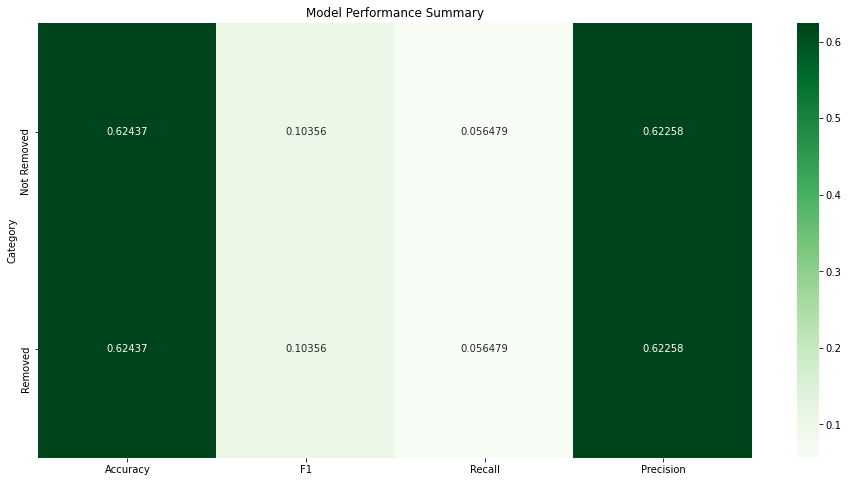

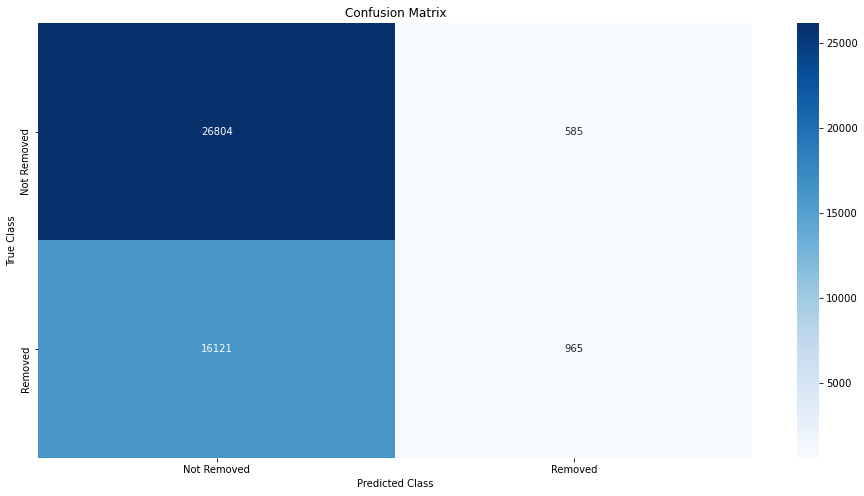

In [18]:
#baseline NB
#just tfidf, no lemma or stopword removal
X = data_cleaned['body']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

tfidf = TfidfVectorizer(max_features=100)

X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

baseline_model = MultinomialNB()

baseline_model.fit(X_train_vectorized, y_train)

labels = ['Not Removed', 'Removed']
test_baseline = getScore(baseline_model, X_test_vectorized, y_test, labels)
conf_baseline = getConfusionMatrix(baseline_model, X_test_vectorized, y_test, labels)

In [16]:
#baseline is only about %0.7 better than just picking majority class (not removed)
y_test.value_counts(normalize=True)
#need to fix getScore, probably rewrite it

False    0.615829
True     0.384171
Name: REMOVED, dtype: float64

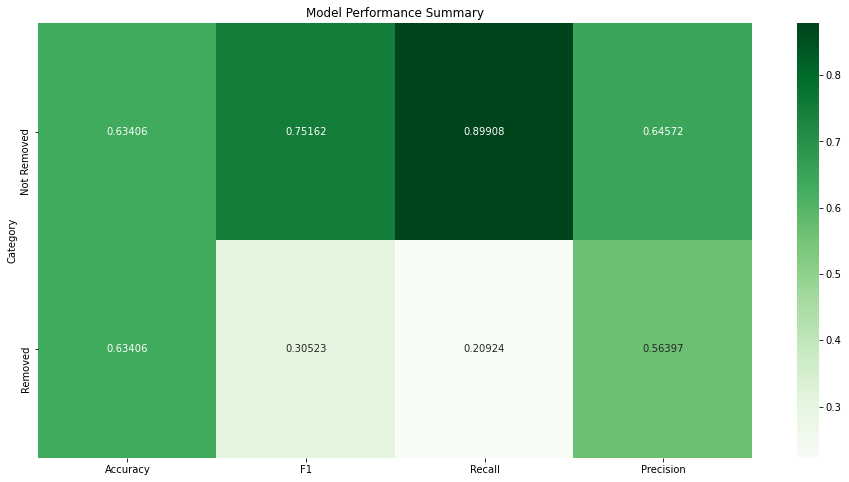

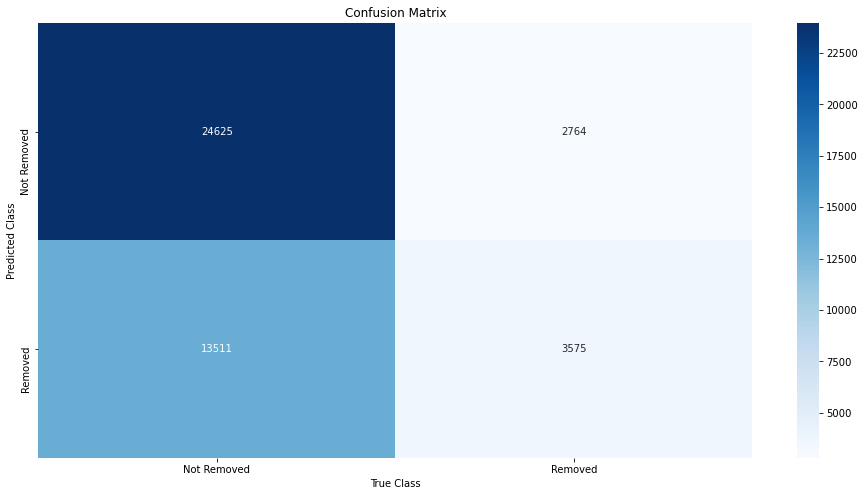

In [13]:
#NB with stopwords removed and lemmatizing (also higher max features)
X = data_cleaned['clean_string']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

tfidf = TfidfVectorizer(max_features=300)

X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

NB_stop_lemma = MultinomialNB()
NB_stop_lemma.fit(X_train_vectorized, y_train)

test_NB_stop_lemma = getScore(NB_stop_lemma, X_test_vectorized, y_test, labels)
conf_NB_stop_lemma = getConfusionMatrix(NB_stop_lemma, X_test_vectorized, y_test, labels)

In [19]:
#very slightly better than baseline, still barely better than always picking majority

In [ ]:
#insert autoembedding lstm here

In [31]:
#use this same split for w2v lstm
X = data_cleaned['clean_string']
y = data_cleaned['REMOVED']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=8492)

if exists('models/w2v_1'):
    w2v = gensim.models.word2vec.Word2Vec.load('models/w2v_1')
    
else:


    w2v_train = X_train.copy()

    #turn into list of lists for gensim
    w2v_train_list = []
    for text in w2v_train:
        list_words = text.split()
        w2v_train_list.append(list_words)

    #train w2v
    w2v = gensim.models.word2vec.Word2Vec(w2v_train_list, size=300,   
                window=8, min_count=1, sg=1, iter=30)

    w2v.save('models/w2v_1')

In [ ]:
#need to clean up code to get embeddings